In [117]:
import json
import tifffile
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [118]:
import os
os.chdir("/home/ws/er5241/Repos/training-repo/")

from inference import Segmenter
from segmenetation_losses_pytorch import CrossentropyND

criterion = CrossentropyND()

In [119]:
# load non-merged  (2022-06-28_11-33-37)
model = {'network_type': 'Unet', 'encoder_name': 'resnet18', 'classes': 10, 'in_channels': 1}
checkpoint = {'checkpoint_addr': '/home/ws/er5241/logs/medaka-supervised/2022-06-28_11-33-37/logdir/checkpoints/best.pth',
              'checkpoint_key': 'model_state_dict'}
processing = {'batch_size': 1, 'dtype': 'uint8'}

seger = Segmenter(model_config=model, checkpoint_config=checkpoint, processing_parameters=processing)

>>>>>>>>>>>>>>>> initializing model
trainable parameters in model: 14323242
<<<<<<<<<<<<<<<< done in 0.38 sec.
>>>>>>>>>>>>>>>> loading checkpoint
<<<<<<<<<<<<<<<< done in 0.084 sec.


In [120]:
volumes = ['/mnt/HD-LSDF/Medaka/201905_beamtime_medaka_stained/*/scaled_0.5_8bit_slices.tif',
           '/mnt/HD-LSDF/Medaka/201912_beamtime_medaka/*/scaled_0.5_8bit_slices.tif',
           '/mnt/HD-LSDF/Medaka/202012_beamtime_medaka/*/scaled_0.5_8bit_slices.tif']
  
len(glob(volumes[0]))

0

In [72]:
fls = glob(volumes[0])
transform = T.Resize((256,256))
losses = {}

def slc_transform(slc):
  slc = torch.from_numpy(slc)
  slc = torch.unsqueeze(slc, 0) # for channel dim
  slc = transform(slc)
  slc = torch.unsqueeze(slc, 0) # for batch dim
  slc = slc.float()
  return slc

def bin_img(img):
  bins, total_classes = 10, 256
  binned_img = np.zeros_like(img)
  for class_ in range(1, bins):
    binned_img[img > int(class_ * (total_classes/bins))] = class_
  return binned_img

In [ ]:
for img_addr in tqdm(fls):
  losses[img_addr] = []
  img = tifffile.imread(img_addr)
  msk = bin_img(img)

  img = img/256
  
  for slice_id, (img_slc, msk_slc) in enumerate(zip(img, msk)):
    img_slc = slc_transform(img_slc)
    msk_slc = slc_transform(msk_slc).to(device)

    predn_slc = seger.model(img_slc)
    loss = criterion(predn_slc, msk_slc)

    losses[img_addr].append( loss.item() )

In [30]:
# with open('/home/ws/er5241/Repos/training-repo/utilities/autoenc_201905.json', 'w') as f:
#     json.dump(losses, f)

In [121]:
# losses_1 = "/home/ws/er5241/Repos/training-repo/utilities/autoenc_medaka_decropped.json"
# losses_2 = "/home/ws/er5241/Repos/training-repo/utilities/autoenc_201905.json"
# losses_3 = "/home/ws/er5241/Repos/training-repo/utilities/autoenc_201912.json"
# losses_4 = "/home/ws/er5241/Repos/training-repo/utilities/autoenc_202012.json"

# losses = {}
# for loss_json in [losses_1, losses_2, losses_3, losses_4]:
#   with open(loss_json, 'r') as f:
#     losses.update(json.load(f))
    
with open('/home/ws/er5241/Repos/training-repo/utilities/autoenc_losses.json', 'r') as f:
    losses = (json.load(f))

In [122]:
loss_vals = []

for addr in losses.values():
  for slc in addr:
    loss_vals.append(slc)

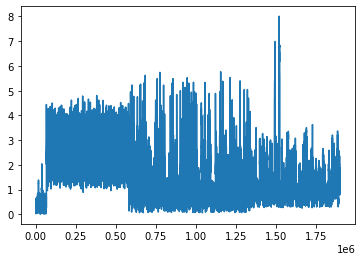

In [123]:
plt.plot(loss_vals)

  0%|          | 0/200 [00:00<?, ?it/s]

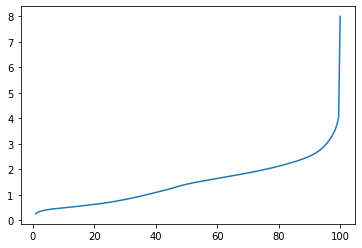

In [110]:
x = np.linspace(1,100,200)
y = np.array([np.percentile(loss_vals, i) for i in tqdm(x)])

plt.plot(x,y)

In [127]:
1-len([loss_val for loss_val in loss_vals if loss_val>3])/len(loss_vals)

0.9551808520101716

In [131]:
np.percentile(loss_vals, 95)

2.933961582183837

### check image

In [116]:
loss_thresh = 8

for img_addr, loss_dict in losses.items():
  for slice_id, slice_loss in enumerate(loss_dict):
    if slice_loss >= loss_thresh:
      print(img_addr, slice_id, slice_loss)

/mnt/HD-LSDF/Medaka/202012_beamtime_medaka/Medaka_1100_14-2/scaled_0.5_8bit_slices.tif 428 8.008149147033691


In [67]:
img_addr = np.random.choice(list(losses.keys()))
fish_id = img_addr.rsplit('/', 1)[-1]
msk_addr = f"{'/'.join(img_addr.split('/')[:-1])}/brain_scaled_0.5_8bit_slices.tif"
print(img_addr)

problematic_slices = []
for slice_id, slice_loss in losses[img_addr].items():
  if slice_loss['loss'] >= loss_thresh:
    problematic_slices.append(slice_id)

if not problematic_slices:
  print(f'no loss greater than {loss_thresh}')

/mnt/HD-LSDF/Medaka/201905_beamtime_medaka_stained/Medaka_761_Ho5_old/scaled_0.5_8bit_slices.tif


In [68]:
print(problematic_slices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 30, 31, 39, 40, 41, 43, 49, 50, 51, 53, 54, 55, 56, 57, 82, 2286, 2289, 2290]
